In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)
%load_ext skip_kernel_extension

In [2]:
import keras_tuner as kt


In [3]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
tf.random.set_seed(2022)

In [4]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = True

## Loading Data

In [5]:
base_df = pd.read_csv("extended_preprocessed_data.csv")
base_df = set_timestamp_index(base_df,"Unnamed: 0")

In [6]:
base_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,6378.0,25385.0,65.41,28251.0,2866.0,2866.0,1,1,0,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,5890.0,24382.0,64.92,27818.0,3436.0,6302.0,1,1,0,1
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,5461.0,22734.0,64.48,26796.0,4062.0,10364.0,1,1,0,2
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,5238.0,21286.0,59.32,25223.0,3937.0,14301.0,1,1,0,3
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,4935.0,20264.0,56.04,24620.0,4356.0,18657.0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,3113.0,30653.0,77.02,26415.0,-4238.0,-2062312.5,12,31,0,19
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,3288.0,29735.0,76.16,25213.0,-4522.0,-2066834.5,12,31,0,20
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,3503.0,28071.0,74.30,23987.0,-4084.0,-2070918.5,12,31,0,21
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,3586.0,25801.0,69.89,22748.0,-3053.0,-2073971.5,12,31,0,22


In [7]:
combined_df = base_df.diff().dropna()
combined_df.index = combined_df.index.tz_convert('utc')

In [8]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+00:00,0.000,0.0,0.0,0.0,0.0,2.0,-1.0,352.0,-66.0,-4.0,...,-488.0,-1003.0,-0.49,-433.0,570.0,3436.0,0.0,0.0,0.0,1.0
2015-01-01 01:00:00+00:00,-0.789,1.0,1.0,-1.0,-39.0,-1.0,-5.0,-339.0,-174.0,-1.0,...,-429.0,-1648.0,-0.44,-1022.0,626.0,4062.0,0.0,0.0,0.0,1.0
2015-01-01 02:00:00+00:00,0.000,0.0,0.0,0.0,0.0,-10.0,-69.0,-543.0,-450.0,3.0,...,-223.0,-1448.0,-5.16,-1573.0,-125.0,3937.0,0.0,0.0,0.0,1.0
2015-01-01 03:00:00+00:00,0.000,0.0,0.0,0.0,0.0,-10.0,-67.0,-184.0,-291.0,-4.0,...,-303.0,-1022.0,-3.28,-603.0,419.0,4356.0,0.0,0.0,0.0,1.0
2015-01-01 04:00:00+00:00,0.606,2.0,-7.0,2.0,298.0,-18.0,-9.0,-92.0,-250.0,0.0,...,-317.0,-359.0,-2.41,-389.0,-30.0,4326.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-3.510,0.0,18.0,-1.0,0.0,4.0,0.0,41.0,24.0,0.0,...,161.0,1061.0,-0.59,878.0,-183.0,-4238.0,0.0,0.0,0.0,1.0
2018-12-31 19:00:00+00:00,-2.500,1.0,9.0,-1.0,102.0,-1.0,0.0,-393.0,-62.0,-4.0,...,175.0,-918.0,-0.86,-1202.0,-284.0,-4522.0,0.0,0.0,0.0,1.0
2018-12-31 20:00:00+00:00,-1.480,0.0,10.0,2.0,58.0,-4.0,0.0,-216.0,-144.0,-6.0,...,215.0,-1664.0,-1.86,-1226.0,438.0,-4084.0,0.0,0.0,0.0,1.0
2018-12-31 21:00:00+00:00,-1.520,0.0,0.0,-1.0,10.0,1.0,0.0,-463.0,-129.0,-5.0,...,83.0,-2270.0,-4.41,-1239.0,1031.0,-3053.0,0.0,0.0,0.0,1.0


# Encode- Decoder + LSTM

Scale the input data

In [9]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [15]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-28'
feature = 'total load actual'
namespace= 'MS_EDLSTM_WL6'
modeltype = 'EDLSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [16]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24*14,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24*14,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24*14,24,32)


In [17]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17152, 336, 28) (17152, 24)
(1024, 336, 28) (1024, 24)
(256, 336, 28) (256, 24)


In [24]:
idx_init = idx_test[0] - timedelta(hours=1)

In [25]:
start = idx_test[0]
end= idx_test[0]+ timedelta(hours=23)

In [29]:
init = np.array(base_df.loc[idx_init,feature])

In [34]:
prediction = np.insert(data_y_test[0],0,init)

In [40]:
prediction.cumsum()[1:]

array([24214., 23173., 22844., 22757., 23453., 25974., 29265., 31604.,
       32426., 32524., 32276., 32017., 31644., 30656., 30115., 29683.,
       29475., 29425., 31679., 33805., 33164., 30549., 27769., 25842.])

In [39]:
base_df[start:end][feature]

2017-03-15 01:00:00+01:00    24214.0
2017-03-15 02:00:00+01:00    23173.0
2017-03-15 03:00:00+01:00    22844.0
2017-03-15 04:00:00+01:00    22757.0
2017-03-15 05:00:00+01:00    23453.0
2017-03-15 06:00:00+01:00    25974.0
2017-03-15 07:00:00+01:00    29265.0
2017-03-15 08:00:00+01:00    31604.0
2017-03-15 09:00:00+01:00    32426.0
2017-03-15 10:00:00+01:00    32524.0
2017-03-15 11:00:00+01:00    32276.0
2017-03-15 12:00:00+01:00    32017.0
2017-03-15 13:00:00+01:00    31644.0
2017-03-15 14:00:00+01:00    30656.0
2017-03-15 15:00:00+01:00    30115.0
2017-03-15 16:00:00+01:00    29683.0
2017-03-15 17:00:00+01:00    29475.0
2017-03-15 18:00:00+01:00    29425.0
2017-03-15 19:00:00+01:00    31679.0
2017-03-15 20:00:00+01:00    33805.0
2017-03-15 21:00:00+01:00    33164.0
2017-03-15 22:00:00+01:00    30549.0
2017-03-15 23:00:00+01:00    27769.0
2017-03-16 00:00:00+01:00    25842.0
Freq: H, Name: total load actual, dtype: float64

Define LSTM Model

In [43]:
def build_model_ED_LSTM():
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential()
    # Encoder
    model.add(layers.LSTM(64, return_sequences=True,input_shape=(None, n_features), stateful=False)) 
    model.add(layers.BatchNormalization())
    
    for i in range(4):
        model.add(layers.LSTM(64, return_sequences=True, stateful=False))
        model.add(layers.BatchNormalization())
      
    model.add(layers.LSTM(64, return_sequences=False, stateful=False)) 
    model.add(layers.BatchNormalization())  
    
    # Repeat Vector
    model.add(layers.RepeatVector(n_outputs))
    
    # Decoder
    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    
    model.add(layers.BatchNormalization())

    for i in range(4):
        model.add(layers.LSTM(64, return_sequences=True, stateful=False))
        model.add(layers.BatchNormalization())

    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())

    # End
    model.add(layers.TimeDistributed(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal")))
    
    model.add(layers.TimeDistributed(layers.LeakyReLU(alpha=0.1)))                     
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.Dense(1)))                     
                
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [44]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [45]:
num_epochs = 150
batch_size = 32

In [46]:
%%skip $SKIP_RETRAIN_ED_LSTM
model_ED_LSTM= build_model_ED_LSTM()
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

In [47]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

In [48]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [49]:
model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          23808     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          3

In [130]:
i=9
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = base_df.loc[Y_test_predictions.index][feature]


In [131]:
def convert_from_differencing(Y_test_predictions,base_df,feature):
    idx_init = Y_test_predictions.index[0] - timedelta(hours=1)
    init_val = base_df.loc[idx_init,feature]
    Y_test_predictions.loc[idx_init] = init
    Y_test_predictions.sort_index(inplace=True)
    Y_test_predictions = Y_test_predictions.cumsum()[1:]
    return Y_test_predictions

Y_test_predictions = convert_from_differencing(Y_test_predictions,base_df,feature)

In [132]:
# idx_init = idx_test[i] - timedelta(hours=1)
# start = idx_test[i]
# end= idx_test[i]+ timedelta(hours=23)
# init = base_df.loc[idx_init,feature]
# print(idx_init)
# Y_test_predictions.loc[idx_init] = init
# Y_test_predictions.sort_index(inplace=True)
# Y_test_predictions = Y_test_predictions.cumsum()[1:]

In [133]:
y_test_filtered

2017-03-15 09:00:00+00:00    32524.0
2017-03-15 10:00:00+00:00    32276.0
2017-03-15 11:00:00+00:00    32017.0
2017-03-15 12:00:00+00:00    31644.0
2017-03-15 13:00:00+00:00    30656.0
2017-03-15 14:00:00+00:00    30115.0
2017-03-15 15:00:00+00:00    29683.0
2017-03-15 16:00:00+00:00    29475.0
2017-03-15 17:00:00+00:00    29425.0
2017-03-15 18:00:00+00:00    31679.0
2017-03-15 19:00:00+00:00    33805.0
2017-03-15 20:00:00+00:00    33164.0
2017-03-15 21:00:00+00:00    30549.0
2017-03-15 22:00:00+00:00    27769.0
2017-03-15 23:00:00+00:00    25842.0
2017-03-16 00:00:00+00:00    24324.0
2017-03-16 01:00:00+00:00    23345.0
2017-03-16 02:00:00+00:00    23010.0
2017-03-16 03:00:00+00:00    22906.0
2017-03-16 04:00:00+00:00    23439.0
2017-03-16 05:00:00+00:00    25669.0
2017-03-16 06:00:00+00:00    28850.0
2017-03-16 07:00:00+00:00    31307.0
2017-03-16 08:00:00+00:00    32065.0
Freq: H, Name: total load actual, dtype: float64

In [134]:
Y_test_predictions


2017-03-15 09:00:00+00:00    26390.500977
2017-03-15 10:00:00+00:00    26548.598175
2017-03-15 11:00:00+00:00    26536.328502
2017-03-15 12:00:00+00:00    26476.087634
2017-03-15 13:00:00+00:00    25397.148425
2017-03-15 14:00:00+00:00    24655.934497
2017-03-15 15:00:00+00:00    24438.313098
2017-03-15 16:00:00+00:00    24438.794934
2017-03-15 17:00:00+00:00    24423.857935
2017-03-15 18:00:00+00:00    25997.540796
2017-03-15 19:00:00+00:00    28021.916528
2017-03-15 20:00:00+00:00    27230.503687
2017-03-15 21:00:00+00:00    24449.816919
2017-03-15 22:00:00+00:00    21574.947534
2017-03-15 23:00:00+00:00    19340.658960
2017-03-16 00:00:00+00:00    17582.495630
2017-03-16 01:00:00+00:00    16595.811121
2017-03-16 02:00:00+00:00    16158.914636
2017-03-16 03:00:00+00:00    16106.059026
2017-03-16 04:00:00+00:00    16662.821050
2017-03-16 05:00:00+00:00    19056.177496
2017-03-16 06:00:00+00:00    22724.315923
2017-03-16 07:00:00+00:00    25108.055669
2017-03-16 08:00:00+00:00    26160

In [135]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

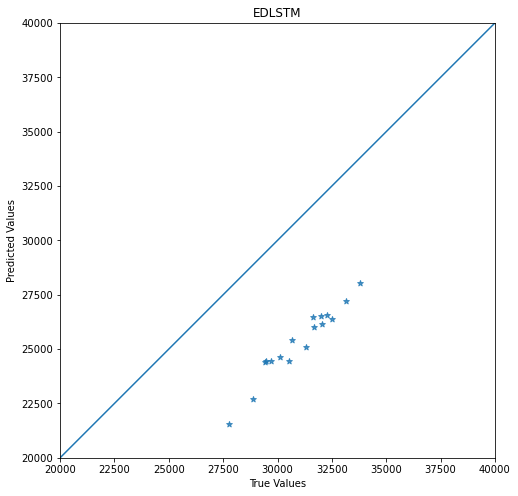

In [136]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")

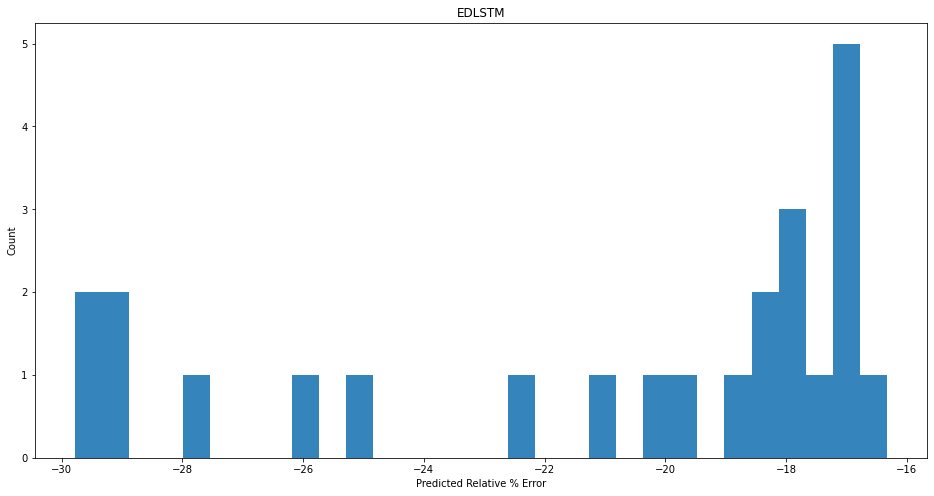

In [137]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [138]:
abs_error_ED_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_ED_LSTM)

21.15230394355707

In [139]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -1.99


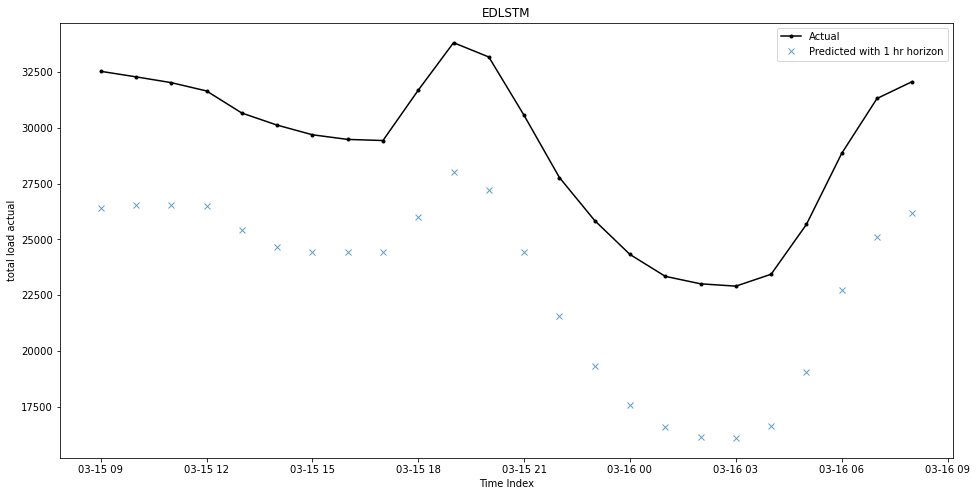

In [140]:
fig=plot_predictions(eval_df,1,modeltype,feature,f"./{modeltype}/predictions_{namespace}.png")

In [116]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [120]:
def make_twoweek_predictions(idx_test,data_y_test0,data_x_test):
    idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
    # y_test_filtered2 = data_y_test0.loc[idx_prediction]
    y_test_filtered2 = base_df.loc[idx_prediction][feature]
    df_pred =pd.DataFrame(index=y_test_filtered2.index)
        
    for i in range(len(data_x_test)):
        case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
        date_range = pd.date_range(start=idx_test[i],freq='h',periods=24)
        Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=date_range)
        
        Y_test_predictions = convert_from_differencing(Y_test_predictions,base_df,feature)
        df_pred[f'pred_{i}'] = Y_test_predictions
        
    df_pred['mean'] = df_pred.mean(axis=1)
    df_pred['Actual'] = y_test_filtered2
    return df_pred

def calculate_r2_scores(df_pred):
    r2_list=[]
    for column in df_pred.columns:
        if column not in ['Actual','mean']:
            pred = df_pred[column].dropna()
            act = df_pred.loc[pred.index,'Actual']
            r2= r2_score(pred,act)
            r2_list.append(r2)
    return r2_list      
    
def plot_twoweek_predictions(df_pred,path,add_traces = False):
    mpl.rcParams['figure.figsize'] = [16, 8.0]
    fig,ax = plt.subplots(1)
    ax.plot(df_pred.index,df_pred['Actual'])
    ax.plot(df_pred.index,df_pred['mean'])
    if add_traces:
        for column in df_pred.columns:
            if column not in ['Actual','mean']:
                ax.plot(df_pred[column],'o')
    fig.savefig(path)
    return fig
    pass



In [121]:
df_pred = make_twoweek_predictions(idx_test=idx_test,data_y_test0=data_y_test0,data_x_test=data_x_test)

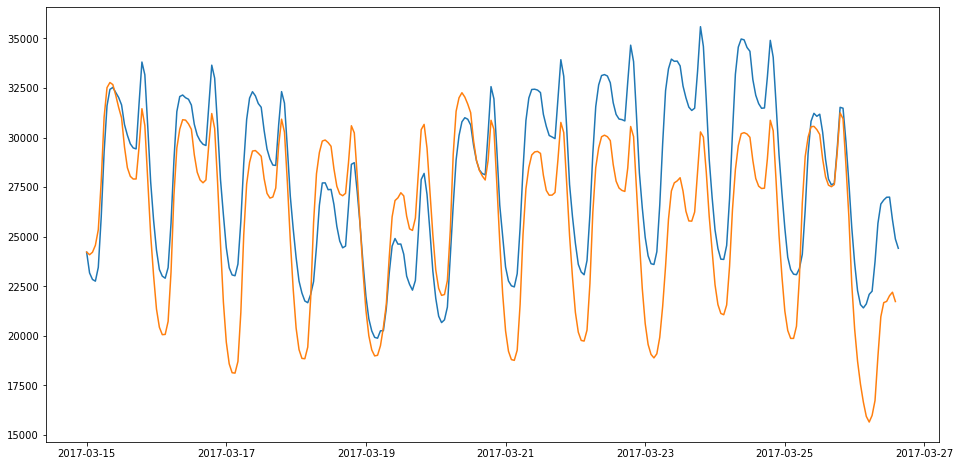

In [127]:
fig = plot_twoweek_predictions(df_pred,f'./{modeltype}/twoweek_predictions_{namespace}.png',add_traces=False)

(-1.0, 1.0)

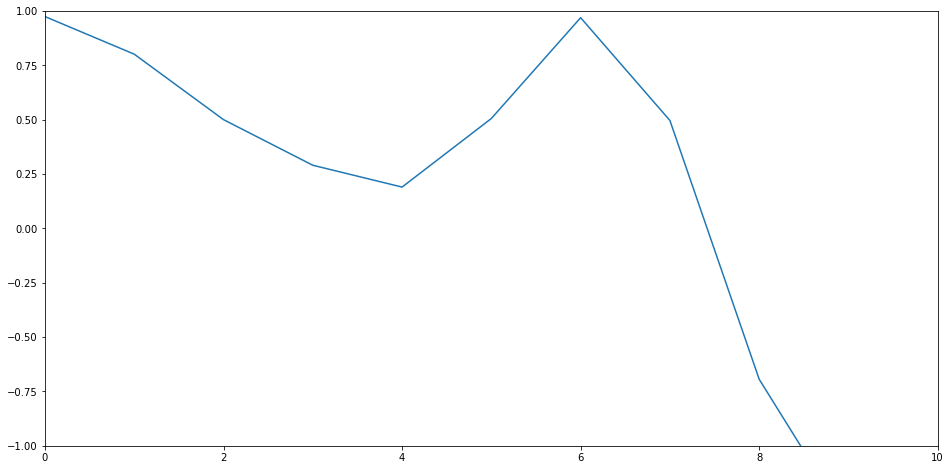

In [129]:
r2 = calculate_r2_scores(df_pred)
plt.figure()
plt.plot(r2)
plt.xlim(0,10)
plt.ylim(-1,1)

In [124]:
sum(r2)/len(r2)

-0.7498902925663138

In [125]:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  -341.93


In [ ]:
eval_df2 = create_eval_df(df_pred['mean'][:-1],y_test_filtered2[:-1])

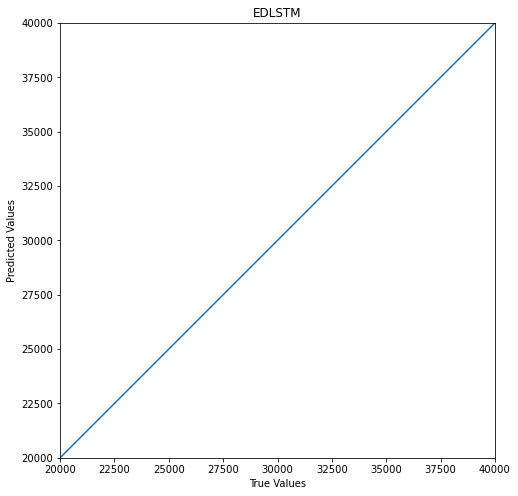

In [ ]:
fig = plot_accuracy(eval_df2,modeltype,f"./{modeltype}/accuracy3_{namespace}.png")

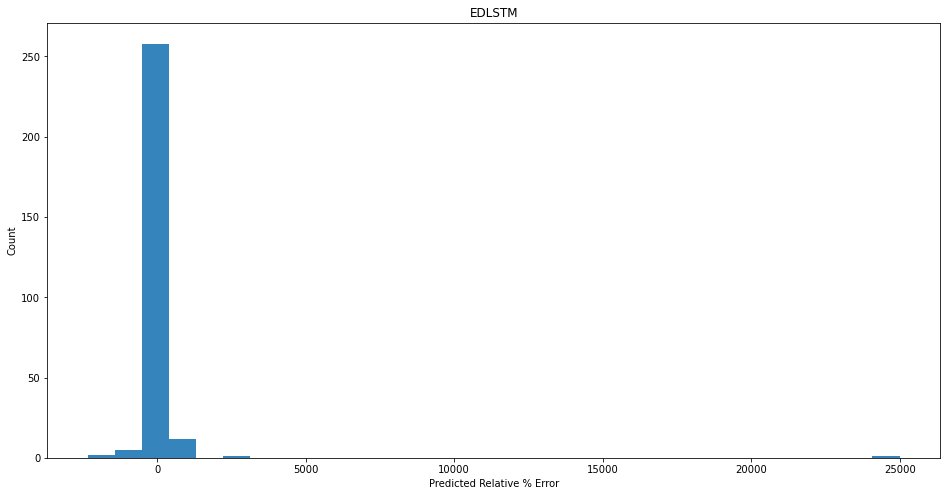

In [ ]:
fig = plot_error_variations(eval_df2,modeltype,f"./{modeltype}/error_variations3_{namespace}.png")